# Analysis of European Elections Results in France

**Understanding the geographical spread of the far-right vote in Southern France.**

*Mainly based on this PySAL notebook: https://nbviewer.jupyter.org/github/pysal/esda/blob/master/notebooks/Spatial%20Autocorrelation%20for%20Areal%20Unit%20Data.ipynb*

To be completed...

## Import librairies

In [1]:
from matplotlib import colors
from unidecode import unidecode

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sbn
import swifter

import esda 
import libpysal as lps
import mapclassify as mc

%matplotlib inline
# %load_ext autotime

## Data preprocessing

In [2]:
PATH_TO_FOLDER = os.getcwd()
PATH_TO_DATA = PATH_TO_FOLDER + '/data'
PATH_TO_RESULTS = PATH_TO_FOLDER + '/results'

### Cities

In [3]:
gdf = gpd.read_file(
    PATH_TO_DATA + '/communes-20190101-shp/communes-20190101.shp'
).sort_values("insee").reset_index(drop=True)
gdf["nom"] = gdf["nom"].swifter.apply(
    unidecode
).swifter.apply(lambda x: x.replace("-", " "))
gdf.head()

/home/michael/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,insee,nom,wikipedia,surf_ha,geometry
0,01001,L'Abergement Clemenciat,fr:L'Abergement-Clémenciat,1567.0,"POLYGON ((4.90298 46.15828, 4.90299 46.15835, ..."
1,01002,L'Abergement de Varey,fr:L'Abergement-de-Varey,909.0,"POLYGON ((5.40408 46.00793, 5.40434 46.00813, ..."
2,01004,Amberieu en Bugey,fr:Ambérieu-en-Bugey,2449.0,"POLYGON ((5.32722 45.95685, 5.32740 45.95680, ..."
3,01005,Amberieux en Dombes,fr:Ambérieux-en-Dombes,1602.0,"POLYGON ((4.87552 45.98726, 4.87564 45.98729, ..."
4,01006,Ambleon,fr:Ambléon,597.0,"POLYGON ((5.57068 45.75369, 5.57255 45.75382, ..."


### Results by city

In [4]:
df = pd.read_csv(
    PATH_TO_DATA + '/resultats-definitifs-par-commune.csv', sep=";"
).sort_values(["Code du département", "Code de la commune"]).reset_index(drop=True)
df["Libellé de la commune"] = df["Libellé de la commune"].swifter.apply(
    unidecode
).swifter.apply(lambda x: x.replace("-", " "))
df["Libellé du département"] = df["Libellé du département"].swifter.apply(
    unidecode
)
df.head()

/home/michael/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/michael/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,...,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255
0,1,Ain,1,L'Abergement Clemenciat,601,268,44.59,333,55.41,1,...,0,0.0,0.0,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,0.00,0.00
1,1,Ain,2,L'Abergement de Varey,210,69,32.86,141,67.14,4,...,0,0.0,0.0,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,0.00,0.00
2,1,Ain,4,Amberieu en Bugey,8110,3975,49.01,4135,50.99,97,...,0,0.0,0.0,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,48,0.59,1.21
3,1,Ain,5,Amberieux en Dombes,1188,596,50.17,592,49.83,16,...,0,0.0,0.0,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,0.00,0.00
4,1,Ain,6,Ambleon,100,34,34.00,66,66.00,1,...,0,0.0,0.0,34,EUROPE AU SERVICE PEUPLES,UNE EUROPE AU SERVICE DES PEUPLES,AZERGUI Nagib,0,0.00,0.00


In [5]:
listes_abrege = [df['Libellé Abrégé Liste'][0]] + [
    df['Unnamed: {}'.format(ind)][0] for ind in range(26, 26 + 7 * 32 + 1, 7)
]
listes_etendu = [df['Libellé Etendu Liste'][0]] + [
    df['Unnamed: {}'.format(ind)][0] for ind in range(27, 27 + 7 * 32 + 1, 7)
]
tete_liste = [df['Nom Tête de Liste'][0]] + [
    df['Unnamed: {}'.format(ind)][0] for ind in range(28, 28 + 7 * 32 + 1, 7)
]

df = df.rename(columns={
    'Unnamed: {}'.format(value): 'Voix {}'.format(tete_liste[ind])
    for ind, value in enumerate(range(22, 22 + 7 * 33 + 1, 7))
})
df = df.rename(columns={
    'Unnamed: {}'.format(value): '% Voix/Ins {}'.format(tete_liste[ind])
    for ind, value in enumerate(range(23, 23 + 7 * 33 + 1, 7))
})
df = df.rename(columns={
    'Unnamed: {}'.format(value): '% Voix/Exp {}'.format(tete_liste[ind])
    for ind, value in enumerate(range(24, 24 + 7 * 33 + 1, 7))
})

df = df.rename(columns={
    'Voix': 'Voix {}'.format(tete_liste[0]),
    '% Voix/Ins': '% Voix/Ins {}'.format(tete_liste[0]),
    '% Voix/Exp': '% Voix/Exp {}'.format(tete_liste[0])
})

df = df.drop(columns=[
    'Unnamed: {}'.format(ind + ind_col) for ind in range(25, 25 + 7 * 32 + 1, 7) for ind_col in range(4)
] + ['N°Liste', 'Libellé Abrégé Liste', 'Libellé Etendu Liste', 'Nom Tête de Liste'])

df.to_csv(PATH_TO_RESULTS + '/preprocessed_results.csv')

In [6]:
# df.to_csv(PATH_TO_RESULTS + '/preprocessed_results.csv')

# df = pd.read_csv(
#     PATH_TO_RESULTS + '/preprocessed_results.csv'
# ).sort_values(["Code du département", "Code de la commune"]).reset_index(drop=True)

### Merge results on cities

In [7]:
mdf = gdf.merge(
    df, how='inner', left_on=['nom'], right_on=['Libellé de la commune']
).drop_duplicates(["insee"])

mdf.sample(5)

,insee,nom,wikipedia,surf_ha,geometry,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Inscrits,...,% Voix/Exp THOUY Hélène,Voix BIDOU Olivier,% Voix/Ins BIDOU Olivier,% Voix/Exp BIDOU Olivier,Voix PERSON Christian Luc,% Voix/Ins PERSON Christian Luc,% Voix/Exp PERSON Christian Luc,Voix AZERGUI Nagib,% Voix/Ins AZERGUI Nagib,% Voix/Exp AZERGUI Nagib
19224,64390,Moncaup,fr:Moncaup (Pyrénées-Atlantiques),1148.0,"POLYGON ((-0.08288 43.49351, -0.08284 43.49372...",31,Haute-Garonne,348,Moncaup,56,...,0.00,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0
280,01169,Genouilleux,fr:Genouilleux,410.0,"POLYGON ((4.77199 46.11788, 4.77220 46.11822, ...",1,Ain,169,Genouilleux,429,...,1.32,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0
37241,73021,Arvillard,fr:Arvillard,2921.0,"POLYGON ((6.09937 45.43868, 6.09946 45.43883, ...",73,Savoie,21,Arvillard,687,...,1.34,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0
34429,65368,Pouy,fr:Pouy (Hautes-Pyrénées),190.0,"POLYGON ((0.54379 43.26310, 0.54441 43.26416, ...",65,Hautes-Pyrenees,368,Pouy,33,...,4.35,0,0.00,0.00,0,0.0,0.0,0,0.0,0.0
41665,88320,Nayemont les Fosses,fr:Nayemont-les-Fosses,891.0,"POLYGON ((6.97837 48.28361, 6.97839 48.28374, ...",88,Vosges,320,Nayemont les Fosses,700,...,1.88,1,0.14,0.24,0,0.0,0.0,0,0.0,0.0


In [8]:
# mdf.to_file(PATH_TO_RESULTS + '/merged_data/merged_data.shp')

# mdf = gpd.read_file(PATH_TO_RESULTS + '/merged_data/merged_data.shp')

## Display map of one candidate in France

In [9]:
tete_liste[:3]

['AUBRY Manon', 'DE PREVOISIN Robert', 'CAMUS Renaud']

In [10]:
candidate = "BARDELLA Jordan"
selected_column = '% Voix/Exp {}'.format(candidate)

(41, 51.5)

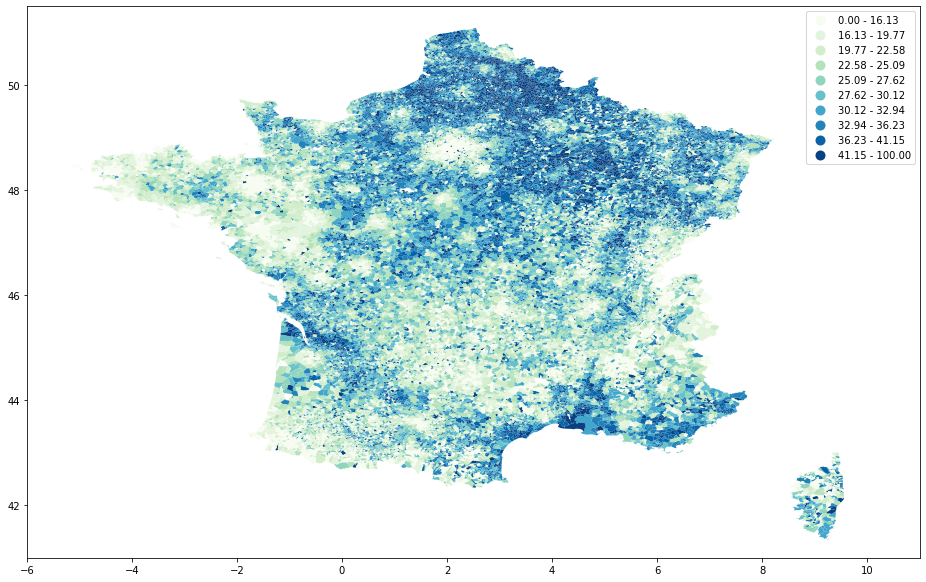

In [11]:
fig, ax = plt.subplots(figsize=(16, 20))
mdf.plot(column=selected_column, scheme='Quantiles', k=10, cmap='GnBu', legend=True, ax=ax)
plt.xlim(-6, 11)
plt.ylim(41, 51.5)

## Display map of one candidate in one department

In [12]:
department = "30"
mdf_department = mdf[mdf["insee"].swifter.apply(lambda x: x[:2]) == department]

/home/michael/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


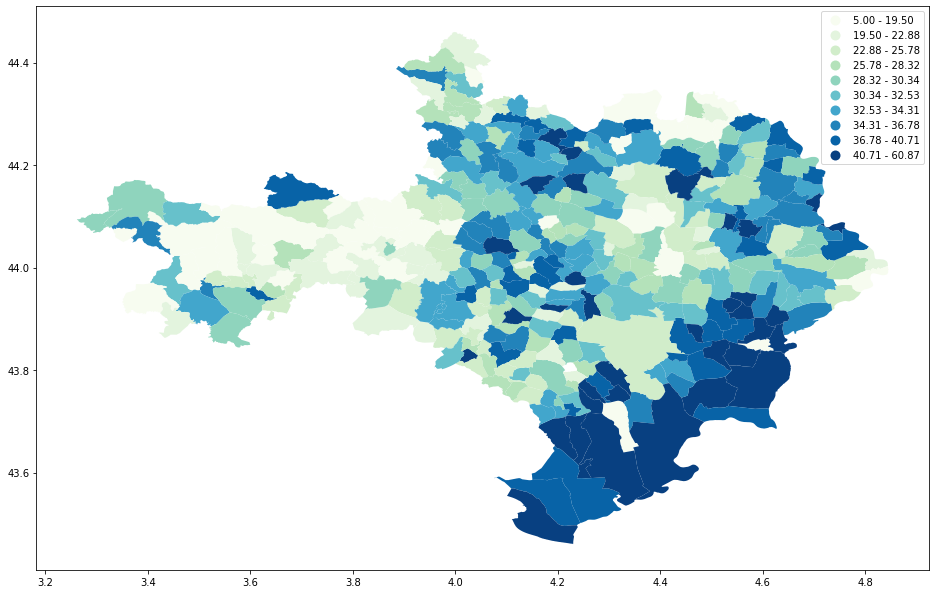

In [13]:
fig, ax = plt.subplots(figsize=(16, 20))
mdf_department.plot(column='% Voix/Exp {}'.format(candidate), scheme='Quantiles', k=10, cmap='GnBu', legend=True, ax=ax)

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of the prices was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters in the south west as well as the center,
and a concentration of the lighter hues (lower prices) in the north central and
south east.

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [14]:
wq =  lps.weights.Queen.from_dataframe(mdf_department)
wq.transform = 'r'

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

In [15]:
y = mdf_department['% Voix/Exp {}'.format(candidate)]
ylag = lps.weights.lag_spatial(wq, y)

In [16]:
ylagq5 = mc.Quantiles(ylag, k=5)

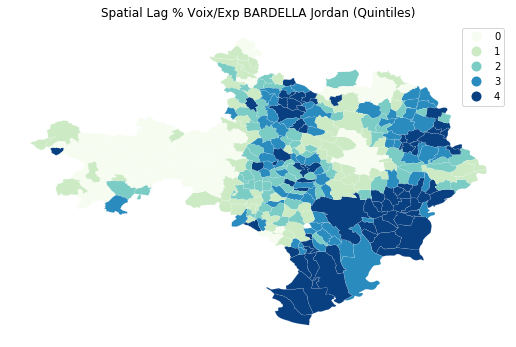

In [17]:
f, ax = plt.subplots(1, figsize=(9, 9))
mdf_department.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag % Voix/Exp {} (Quintiles)".format(candidate))

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

In [18]:
mdf_department.columns

Index(['insee', 'nom', 'wikipedia', 'surf_ha', 'geometry',
       'Code du département', 'Libellé du département', 'Code de la commune',
       'Libellé de la commune', 'Inscrits',
       ...
       '% Voix/Exp THOUY Hélène', 'Voix BIDOU Olivier',
       '% Voix/Ins BIDOU Olivier', '% Voix/Exp BIDOU Olivier',
       'Voix PERSON Christian Luc', '% Voix/Ins PERSON Christian Luc',
       '% Voix/Exp PERSON Christian Luc', 'Voix AZERGUI Nagib',
       '% Voix/Ins AZERGUI Nagib', '% Voix/Exp AZERGUI Nagib'],
      dtype='object', length=125)

/home/michael/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


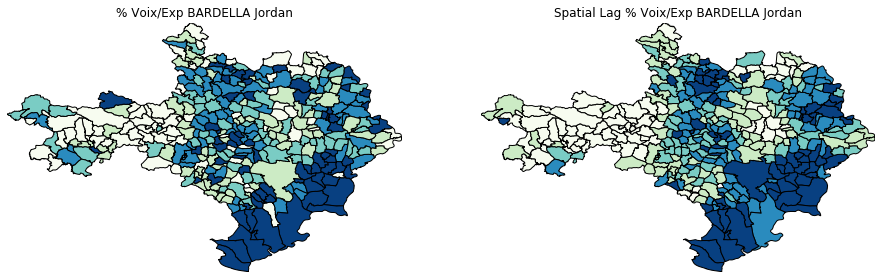

In [19]:
mdf_department['lag_% Voix/Exp {}'.format(candidate)] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4 * 1.8,4 * 1.8))
mdf_department.plot(column='% Voix/Exp {}'.format(candidate), ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(mdf_department.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("% Voix/Exp {}".format(candidate))
mdf_department.plot(column='lag_% Voix/Exp {}'.format(candidate), ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(mdf_department.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag % Voix/Exp {}".format(candidate))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [20]:
mdf_department[mdf_department['Inscrits'] > 8000].sort_values(
    ['% Voix/Exp {}'.format(candidate)], ascending=False
)[['nom', 'Code du département', '% Voix/Exp {}'.format(candidate)]]

,nom,Code du département,% Voix/Exp BARDELLA Jordan
18274,Beaucaire,30,47.83
18589,Saint Gilles,30,43.81
18745,Vauvert,30,42.56
18414,Le Grau du Roi,30,41.18
18256,Bagnols sur Ceze,30,34.78
18220,Ales,30,30.32
18481,Nimes,30,24.43
18758,Villeneuve les Avignon,30,19.18


However, we still have
the challenge of visually associating the value of the prices in a neighborhod
with the value of the spatial lag of values for the focal unit. The latter is a
weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal
statistical measures of spatial autocorrelation.


## Global Spatial Autocorrelation

We begin with a simple case where the variable under consideration is binary.
This is useful to unpack the logic of spatial autocorrelation tests. So  even though
our attribute is a continuously valued one, we will convert it to a binary case
to illustrate the key concepts:

### Binary Case

In [21]:
y.median()

30.345

In [22]:
yb = y > y.median()
sum(yb)

175

We have 68 neighborhoods with list prices above the median and 70 below the
median (recall the issue with ties).

In [23]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
mdf_department['yb'] = yb

/home/michael/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The spatial distribution of the binary variable immediately raises questions
about the juxtaposition of the "black" and "white" areas.

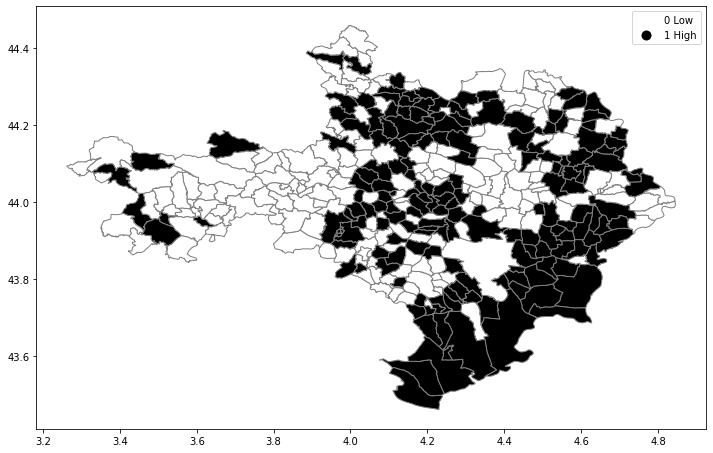

In [24]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
mdf_department.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts ###

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the `esda` package from PySAL to carry out join count analysis:

In [25]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(mdf_department)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

The resulting object stores the observed counts for the different types of joins:

In [26]:
jc.bb

313

In [27]:
jc.ww

292

In [28]:
jc.bw

361

Note that the three cases exhaust all possibilities:

In [29]:
jc.bb + jc.ww + jc.bw

966

and

In [30]:
wq.s0 / 2

966.0

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 121 BB joins:

In [31]:
jc.bb

313

The critical question for us, is whether this is a departure from what we would
expect if the process generating the spatial distribution of the Black polygons
were a completely random one? To answer this, PySAL uses random spatial
permutations of the observed attribute values to generate a realization under
the null of _complete spatial randomness_ (CSR). This is repeated a large number
of times (999 default) to construct a reference distribution to evaluate the
statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [32]:
jc.mean_bb

240

which is less than our observed count. The question is whether our observed
value is so different from the expectation that we would reject the null of CSR?

Text(0.5, 0, 'BB Counts')

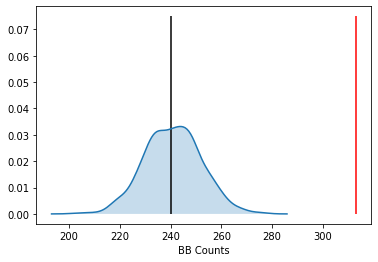

In [33]:
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

The density portrays the distribution of the BB counts, with the black vertical
line indicating the mean BB count from the synthetic realizations and the red
line the observed BB count for our prices. Clearly our observed value is
extremely high. A pseudo p-value summarizes this:

In [34]:
jc.p_sim_bb

0.001

Since this is below conventional significance levels, we would reject the null
of complete spatial randomness in favor of spatial autocorrelation in market prices.


### Continuous Case

The join count analysis is based on a binary attribute, which can cover many
interesting empirical applications where one is interested in presence and
absence type phenomena. In our case, we artificially created the binary variable,
and in the process we throw away a lot of information in our originally
continuous attribute. Turning back to the original variable, we can explore
other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [35]:
wq.transform = 'r'

In [36]:
y = mdf_department['% Voix/Exp {}'.format(candidate)]

Moran's I is a test for global autocorrelation for a continuous attribute:

In [37]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.3190672248646744

Again, our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL uses a similar approach as we saw in
the join count analysis: random spatial permutations.

Text(0.5, 0, "Moran's I")

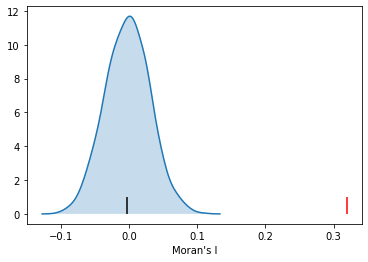

In [38]:
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

Here our observed value is again in the upper tail, although visually it does
not look as extreme relative to the binary case. Yet, it is still statistically significant:

In [39]:
mi.p_sim

0.001

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same
d

In [40]:
np.random.seed(12345)

In [41]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, mdf_department['% Voix/Exp {}'.format(candidate)])

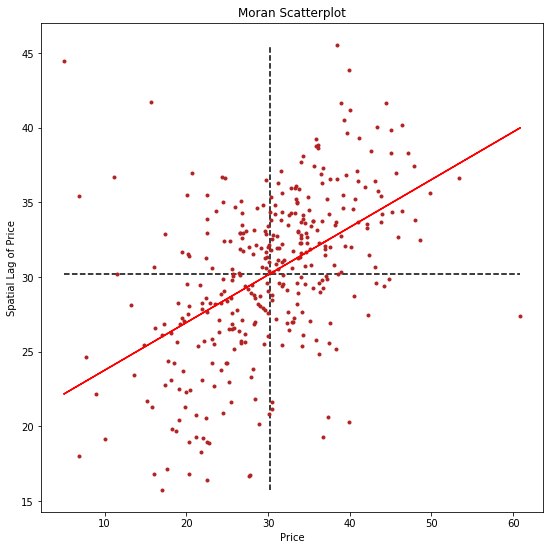

In [42]:
price = mdf_department['% Voix/Exp {}'.format(candidate)]
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [43]:
li = esda.moran.Moran_Local(y, wq)

In [44]:
li.q

array([1, 1, 4, 4, 1, 3, 3, 2, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 4, 4, 3, 1,
       3, 3, 2, 2, 4, 2, 4, 3, 1, 1, 3, 1, 1, 1, 4, 3, 3, 1, 4, 3, 3, 4,
       3, 2, 3, 1, 3, 4, 3, 3, 3, 1, 1, 4, 3, 1, 1, 3, 1, 4, 3, 1, 4, 3,
       4, 2, 2, 1, 1, 4, 4, 3, 4, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1,
       3, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 3, 1, 3, 1, 1, 2, 4, 3, 1, 4,
       3, 1, 3, 3, 3, 2, 2, 2, 3, 1, 4, 2, 1, 1, 3, 3, 1, 3, 3, 3, 2, 4,
       3, 1, 1, 3, 4, 2, 1, 3, 1, 2, 1, 1, 3, 3, 1, 2, 1, 3, 1, 3, 2, 2,
       3, 3, 1, 1, 3, 3, 1, 1, 1, 4, 3, 4, 3, 1, 3, 3, 1, 1, 1, 2, 2, 1,
       1, 2, 4, 4, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 4, 3, 2, 1, 2, 2, 1, 1,
       2, 1, 3, 4, 2, 2, 3, 3, 3, 1, 1, 2, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1,
       4, 2, 3, 1, 1, 1, 1, 2, 1, 4, 3, 3, 4, 2, 4, 2, 1, 3, 1, 3, 4, 1,
       1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 2, 1,
       4, 1, 1, 3, 3, 1, 3, 4, 1, 3, 1, 4, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 4, 1, 4, 1, 3, 3, 4, 3, 3, 4, 3, 2, 1,

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [45]:
(li.p_sim < 0.05).sum()

88

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:

In [46]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [47]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

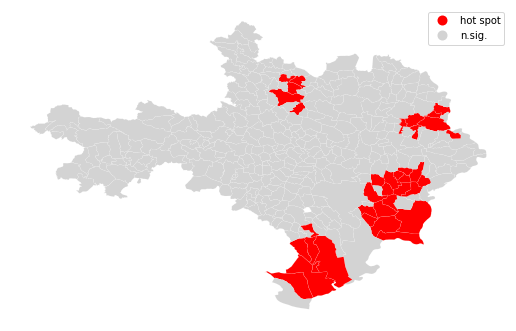

In [48]:
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
mdf_department.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [49]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 0, 0, 3, 0, 0, 0, 0, 1,
       3, 0, 2, 2, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 4, 3, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 1, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0,
       0, 1, 1, 3, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 3, 1, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 1, 3, 0, 3, 0, 0,
       0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 4, 0, 3, 3, 4, 0, 0, 0, 0, 0, 0,

In [50]:
spot_labels = ['0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

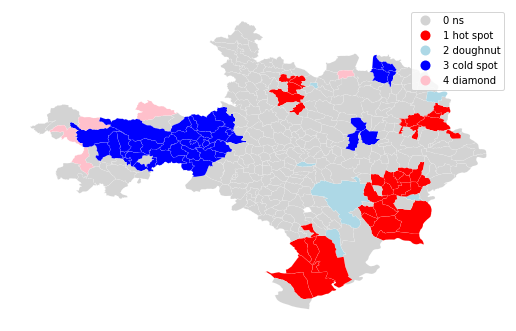

In [51]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
mdf_department.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()